# Pykoopman-AE : Tutorial

### Import libraries

In [18]:
import pykoopman_ae

import torch
import numpy as np
import matplotlib.pyplot as plt

### Device setup

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce GTX 1050 Ti


### Default parameter values for the Autoencoder models

In [20]:
default_params = {
    # Necessary parameters
    'num_original_states': 2,
    'num_lifted_states': 16,
    'num_inputs': 1,

    # MLP Parameters
    "encoder_layers": [16, 64, 16],
    "k_block_layers": [32],
    "b_block_layers": [32],
    "decoder_trainable": False,
    "decoder_layers": [16, 64, 128, 64, 16],

    # TCN Parameters
    'time_window': 5,
    'tcn_channels': [10, 20],
    'tcn_kernels': [3, 2],

    # LSTM Parameters
    'time_window': 5,
    'lstm_hidden_size': 10,
    'lstm_num_layers': 10,

    # GRU Parameters
    'time_window': 5,
    'gru_hidden_size': 10,
    'gru_num_layers': 10,
}

## 1. Non-Temporal Model (MLP_AE)

Build the model using the parametrs dictionary

In [22]:
model_MLP = pykoopman_ae.MLP_AE(params=default_params)
model_MLP.to(device=device)

MLP_AE(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=False)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=64, bias=False)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=False)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=14, bias=False)
    (7): Tanh()
  )
  (k_block): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=False)
    (1): Linear(in_features=32, out_features=16, bias=False)
  )
  (b_block): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=False)
    (1): Linear(in_features=32, out_features=16, bias=False)
  )
)

Test model for an example input of x and u

In [23]:
x = torch.tensor([1,1], dtype=torch.float32).unsqueeze(0).to(device)
u = torch.tensor([1], dtype=torch.float32).to(device)
model_MLP(x, u)

tensor([[-0.1207, -0.1557]], device='cuda:0', grad_fn=<PermuteBackward0>)

Load test data

The dataset should contain:
1. Trajectories - [num_trajectories, num_original_states, len_trajectory]
2. Input - [num_trajectories, num_inputs, len_trajectory]

The example dataset contains 500 trajectories of length 50 timesteps each, generated by a system with 2 states and 1 input.

In [26]:
data_load_path = f"test_data.npy"
trajectory_input = np.load(data_load_path)
trajectory = torch.tensor(trajectory_input[:,:-1,:], dtype=torch.float32).to(device)
input = torch.tensor(np.expand_dims(trajectory_input[:,-1,:], axis=1), dtype=torch.float32).to(device)

print(trajectory.shape)
print(input.shape)

torch.Size([500, 2, 50])
torch.Size([500, 1, 50])


We can learn the Koopman Eigendynamics (Unforced system dynamics) (from unforced system trajectories where input u = 0)

In [59]:
# loss = model_MLP.learn_koopman_eigendynamics(trajectory=trajectory, num_epochs=5, dynamic_loss_window=5, batch_size=256, weight_dynamics_loss=20, weight_prediction_loss=5, weight_reconstruction_loss=2)

After learning the Koopman Eigendynamics, we can learn the Input Matrix (B) as a subsequent step (from forced system trajectories)

In [29]:
# loss = model_MLP.learn_input_matrix(trajectory=trajectory, input=input, num_epochs=5, dynamic_loss_window=5, batch_size=256)

Or preferrably, we can directly learn the Koopman model (K, B, C, encoder) in a single step (from forced system trajectories)

In [30]:
loss = model_MLP.learn_koopman_model(trajectory=trajectory, input=input, num_epochs=5, dynamic_loss_window=5, batch_size=256)

100%|██████████| 500/500 [00:02<00:00, 172.88it/s]


Finished epoch 1, mean loss for the epoch = 0.05829084664583206


100%|██████████| 500/500 [00:02<00:00, 168.30it/s]


Finished epoch 2, mean loss for the epoch = 0.03737138211727142


100%|██████████| 500/500 [00:03<00:00, 164.98it/s]


Finished epoch 3, mean loss for the epoch = 0.026906875893473625


100%|██████████| 500/500 [00:02<00:00, 169.97it/s]


Finished epoch 4, mean loss for the epoch = 0.02031947486102581


100%|██████████| 500/500 [00:02<00:00, 172.08it/s]

Finished epoch 5, mean loss for the epoch = 0.015575127676129341


Plot training loss curve

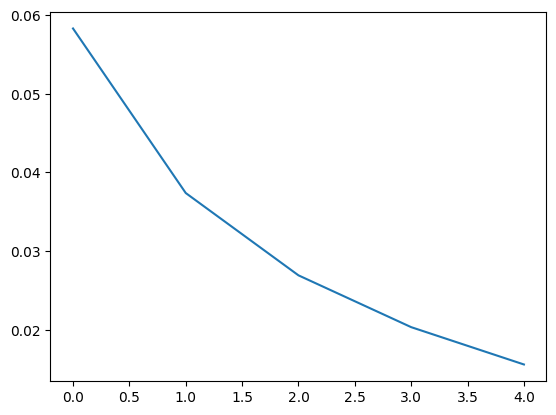

In [38]:
plt.plot(loss)

Get the Koopman model (K, B, C, encoder)

In [41]:
K, B, C, enc = model_MLP.get_koopman_model()
print(K.shape)
print(B.shape)
print(C.shape)

torch.Size([16, 16])
torch.Size([16, 1])
torch.Size([2, 16])


Save Koopman model

In [45]:
path = "tutorial_MLP_AE.pth"
pykoopman_ae.save_koopman_model(model_MLP, default_params, path)

Koopman system saved successfully at tutorial_MLP_AE.pth


Load a saved Koopman model

In [46]:
K, B, C, enc, model = pykoopman_ae.load_koopman_model(path, pykoopman_ae.MLP_AE)

Koopman system loaded successfully from tutorial_MLP_AE.pth


In [47]:
model.to(device)
model(x,u)

tensor([[0.9611, 0.9186]], device='cuda:0', grad_fn=<PermuteBackward0>)

## 2. Temporal Model (TCN_AE, LSTM_AE, GRU_AE)

Build a temporal model using the parameters dictionary

In [50]:
model_TCN = pykoopman_ae.TCN_AE(params=default_params)
model_TCN.to(device)

TCN_AE(
  (tcn): Sequential(
    (0): Conv1d(2, 10, kernel_size=(3,), stride=(1,), bias=False)
    (1): Tanh()
    (2): Conv1d(10, 20, kernel_size=(2,), stride=(1,), bias=False)
    (3): Tanh()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder): Sequential(
    (0): Linear(in_features=40, out_features=16, bias=False)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=64, bias=False)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=False)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=14, bias=False)
    (7): Tanh()
  )
  (k_block): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=False)
    (1): Linear(in_features=32, out_features=16, bias=False)
  )
  (b_block): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=False)
    (1): Linear(in_features=32, out_features=16, bias=False)
  )
)

Convert the dataset to a temporal dataset 
- Add a temporal dimension corresponding to time_window
- The temporal dataset contains:
1. Input States - [num_trajectories, len_trajectory-1, time_window, num_original_states]
2. Output States - [num_trajectories, len_trajectory-1, num_original_states]
3. Input - [num_trajectories, len_trajectory-1, num_inputs]

In [53]:
X, Y, U = pykoopman_ae.get_temporal_dataset(trajectory, input, time_window=5)
X = X.to(device)
Y = Y.to(device)
U = U.to(device)
print(X.shape)
print(Y.shape)
print(U.shape)

torch.Size([500, 49, 5, 2])
torch.Size([500, 49, 2])
torch.Size([500, 49, 1])


Test model for an example input of x and u

In [57]:
model_TCN(X[0,0].unsqueeze(0), U[0,0].unsqueeze(0))

tensor([[0.2273, 0.3564]], device='cuda:0', grad_fn=<PermuteBackward0>)

We can learn the Koopman Eigendynamics (Unforced system dynamics) (from unforced system trajectories where input u = 0)

In [60]:
# loss = model_TCN.learn_koopman_eigendynamics(trajectory=trajectory, num_epochs=5, dynamic_loss_window=5, batch_size=256, weight_dynamics_loss=20, weight_prediction_loss=5, weight_reconstruction_loss=2)

After learning the Koopman Eigendynamics, we can learn the Input Matrix (B) as a subsequent step (from forced system trajectories)

In [61]:
# loss = model_TCN.learn_input_matrix(trajectory=trajectory, input=input, num_epochs=5, dynamic_loss_window=5, batch_size=256)

Or preferrably, we can directly learn the Koopman model (K, B, C, encoder) in a single step (from forced system trajectories)

In [62]:
loss = model_TCN.learn_koopman_model(trajectory=trajectory, input=input, num_epochs=5, dynamic_loss_window=5, batch_size=256)

100%|██████████| 500/500 [00:03<00:00, 136.70it/s]


Finished epoch 1, mean loss for the epoch = 0.13704554736614227


100%|██████████| 500/500 [00:03<00:00, 130.15it/s]


Finished epoch 2, mean loss for the epoch = 0.07050497084856033


100%|██████████| 500/500 [00:03<00:00, 133.50it/s]


Finished epoch 3, mean loss for the epoch = 0.04514460265636444


100%|██████████| 500/500 [00:03<00:00, 137.97it/s]


Finished epoch 4, mean loss for the epoch = 0.02862921915948391


100%|██████████| 500/500 [00:03<00:00, 128.07it/s]

Finished epoch 5, mean loss for the epoch = 0.017129652202129364


Plot training loss curve

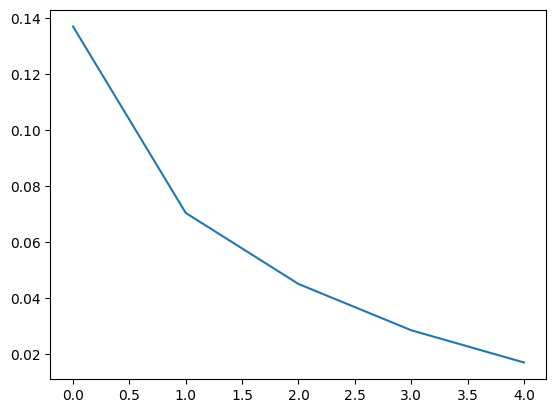

In [64]:
plt.plot(loss)

Get the Koopman model (K, B, C, encoder)

In [66]:
K, B, C, enc = model_TCN.get_koopman_model()
print(K.shape)
print(B.shape)
print(C.shape)

torch.Size([16, 16])
torch.Size([16, 1])
torch.Size([2, 16])


Save Koopman model

In [67]:
path = "tutorial_TCN_AE.pth"
pykoopman_ae.save_koopman_model(model_TCN, default_params, path)

Koopman system saved successfully at tutorial_TCN_AE.pth


Load a saved Koopman model

In [68]:
K, B, C, enc, model = pykoopman_ae.load_koopman_model(path, pykoopman_ae.TCN_AE)

Koopman system loaded successfully from tutorial_TCN_AE.pth


In [70]:
model.to(device)
model(X[0,0].unsqueeze(0), U[0,0].unsqueeze(0))

tensor([[0.5692, 0.9098]], device='cuda:0', grad_fn=<PermuteBackward0>)